In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from pynwb import TimeSeries
from pynwb import NWBHDF5IO
import pandas as pd
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import jax
os.chdir("..")

# Load Data

In [2]:
path = "/stelmo/sam/c3po_datasets/sub-Han_desc-train_behavior+ecephys.nwb"

# nwb file
os.path.exists(path)
io = NWBHDF5IO(path, "r")
nwbfile = io.read()

# behavior data
data = []
for object in nwbfile.objects.values():
    if isinstance(object, TimeSeries):
        if "hand" in object.name.lower() or "hand" in object.description.lower():
            data.append(object)
behavior_df = {}
for d in data:
    for i, dim in enumerate(["x", "y"]):
        behavior_df[f"{d.name}_{dim}"] = d.data[:, i]
behavior_df = pd.DataFrame(behavior_df, index=d.get_timestamps())
trials_df = nwbfile.trials.to_dataframe()

# spikes
units_df = nwbfile.units.to_dataframe()

t_spike = []
id_spike = []
for i, spikes in enumerate(units_df["spike_times"]):
    t_spike.extend(spikes)
    id_spike.extend([i] * len(spikes))
ind = np.argsort(t_spike)
t_spike = np.array(t_spike)[ind]
id_spike = np.array(id_spike)[ind]

delta_t = np.diff(t_spike) * 1000  # convert to ms
waveforms = id_spike[1:].astype(np.int16)

ind_valid = np.where(delta_t > 0)[0]
delta_t = delta_t[ind_valid]
waveforms = waveforms[ind_valid]

delta_t.shape, waveforms.shape

np.mean(delta_t), np.std(delta_t), (t_spike.max() - t_spike.min()) / 60

/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.4.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


(2.78305990204288, 2.57739697813634, 37.05741666666667)

# Load in embedding results

In [368]:
from src.c3po.tables.dev_tables import C3POStorage

C3POStorage()  # .alter()
key = {"model_name": "monkey_s1_bump_reach_REACH_ONLY_16d"}
analysis = (C3POStorage & key).fetch_analysis_object()

analysis.load_embedding(f"/stelmo/sam/c3po_results/{key['model_name']}_embedding.npz")

t_interp = np.arange(analysis.t[0], analysis.t[-1], 0.001)
analysis.interpolate_context(t_interp)
analysis.fit_context_pca()

# Just showing how to access the variables
t = analysis.t
z = analysis.z
c = analysis.c
c_pca = analysis.c_pca
t_interp = analysis.t_interp
c_interp = analysis.c_interp
c_pca_interp = analysis.c_pca_interp
latent_dim, context_dim = analysis.latent_dim, analysis.context_dim

# Analyze

16


(-1.0, 3.0)

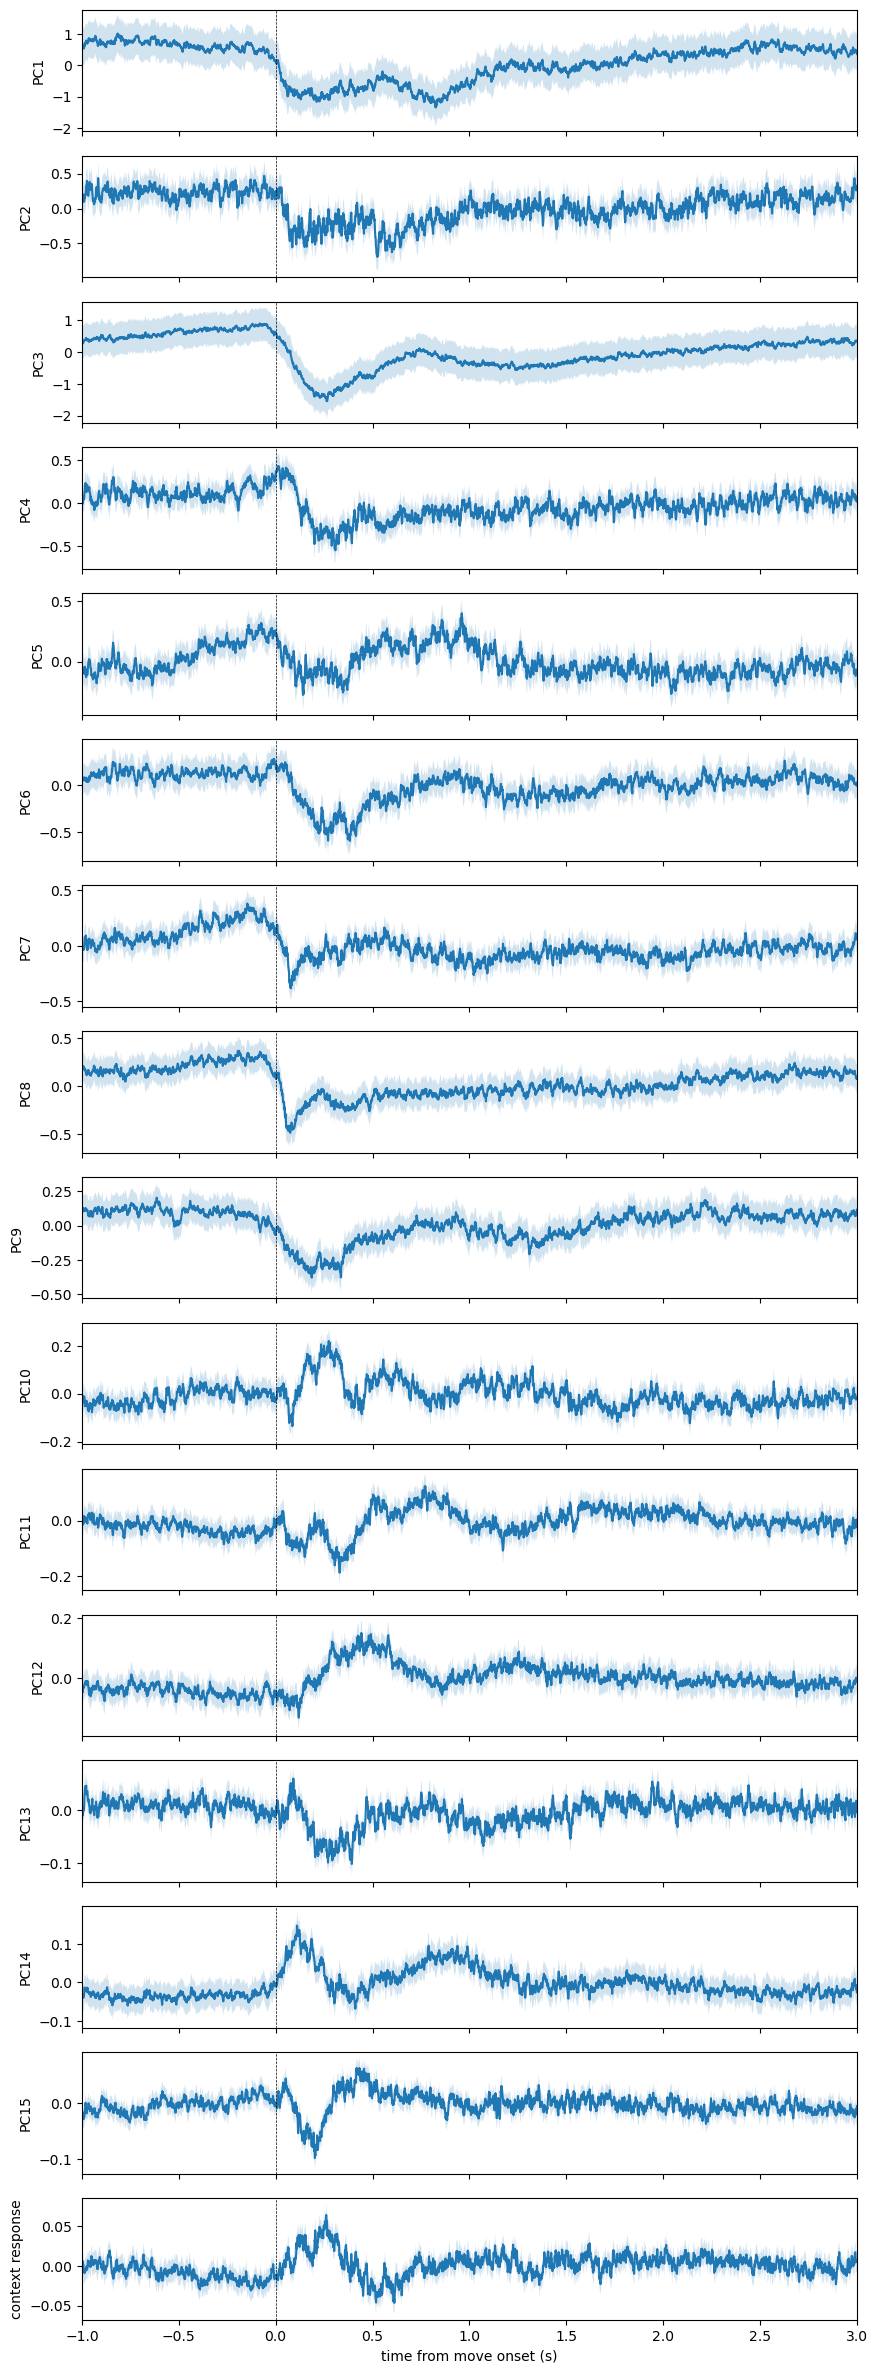

In [ ]:
start_times = trials_df.move_onset_time.values
t_rng = (-1, 3)
fig, ax = plt.subplots(nrows=context_dim, sharex=True, figsize=(10, 30))


response = analysis.alligned_response(start_times, t_rng, pca=True)

response.shape
response = np.mean(response, axis=0)

t = np.linspace(t_rng[0], t_rng[1], response.shape[0])
for i, a in enumerate(ax):
    a.plot(
        t,
        response[:, i],
        label=f"PC{i+1}",
    )
    a.fill_between(
        t,
        response[:, i] - np.std(response[:, i]),
        response[:, i] + np.std(response[:, i]),
        alpha=0.2,
    )
    a.set_ylabel(f"PC{i+1}")
    a.axvline(0, color="k", lw=0.5, ls="--")
# plt.plot(
#     t,
#     response[:, :],
# )
# response = np.array([smooth(response[:, i], 100) for i in range(response.shape[-1])]).T


# plt.plot(response[:, 0], response[:, 1], lw=1)
# plt.scatter(response[0, 0], response[0, 1], s=100, alpha=1,c='k')
# plt.xlabel("PC1")
# plt.ylabel("PC2"    )
print(context_dim)
plt.xlabel("time from move onset (s)")
plt.ylabel("context response")
plt.xlim(t_rng)

0.0
45.0
90.0
135.0
180.0
225.0
270.0
315.0
nan


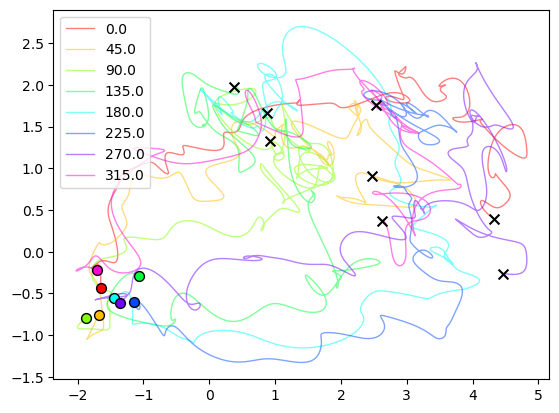

In [8]:
t_rng = (-0.1, 0.5)
# t_rng = (-0.5, 1)
plot_dims = (3, 4)
plot_dims = (0, 1)
# plot_dims = (1, 2)
# plot_dims = (1, 4)
smooth_len = 31


def smooth(x, window_len=11, window="hamming"):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len < 3:
        return x
    if window == "hanning":
        w = np.hanning(window_len)
    elif window == "hamming":
        w = np.hamming(window_len)
    elif window == "blackman":
        w = np.blackman(window_len)
    elif window == "gaussian":
        w = np.hanning(window_len)
        w = np.exp(
            -0.5
            * (np.arange(window_len) - window_len // 2) ** 2
            / (window_len // 6) ** 2
        )
        w /= w.sum()
    else:
        raise ValueError("Window is on of 'hanning', 'hamming', 'blackman'")
    y = np.convolve(w / w.sum(), x, mode="valid")
    return y


for direction in np.unique(trials_df.cond_dir.values):
    print(direction)
    if np.isnan(direction):
        continue
    color = plt.cm.hsv(direction / 360)
    # color=None
    val = trials_df.copy()
    val = val[val.ctr_hold_bump == False]
    val = val[val.cond_dir == direction]
    val = val[val.split != "none"]

    # val = trials_df[np.logical_and(trials_df.target_dir == direction, trials_df.result =='A')]
    # val = trials_df[
    #     trials_df.target_dir == direction
    # ]
    start_times = val.move_onset_time.values
    response = analysis.alligned_response(start_times, t_rng, pca=True)
    response = np.nanmean(response, axis=0)
    response = np.array(
        [
            smooth(response[:, i], window_len=smooth_len, window="gaussian")
            for i in range(response.shape[1])
        ]
    ).T
    # plt.plot(response[:, 0], label=direction)
    plt.plot(
        response[:, plot_dims[0]],
        response[:, plot_dims[1]],
        label=direction,
        lw=1,
        color=color,
        alpha=0.5,
    )
    plt.scatter(
        response[0, plot_dims[0]],
        response[0, plot_dims[1]],
        s=50,
        alpha=1,
        color=color,
        zorder=20,
        edgecolor="k",
    )
    plt.scatter(
        response[-1, plot_dims[0]],
        response[-1, plot_dims[1]],
        s=50,
        alpha=1,
        zorder=20,
        marker="x",
        color="k",
    )
    plt.legend()

0.0
45.0
90.0
135.0
180.0
225.0
270.0
315.0
nan


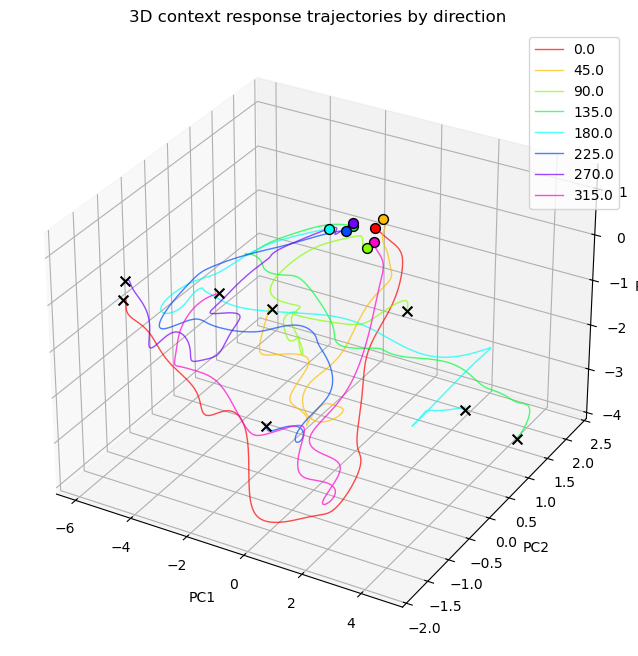

In [620]:
from mpl_toolkits.mplot3d import Axes3D

plot_dims = (0, 1, 2)
# plot_dims = (1, 2, 3)
t_rng = (-0.1, 0.5)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

for direction in np.unique(trials_df.cond_dir.values):
    print(direction)
    if np.isnan(direction):
        continue
    color = plt.cm.hsv(direction / 360)
    val = trials_df.copy()
    val = val[val.ctr_hold_bump == False]
    val = val[val.cond_dir == direction]
    val = val[val.split != "none"]

    start_times = val.move_onset_time.values
    response = analysis.alligned_response(start_times, t_rng, pca=True)
    response = np.mean(response, axis=0)
    response = np.array(
        [
            smooth(response[:, i], window_len=101, window="gaussian")
            for i in range(response.shape[1])
        ]
    ).T
    ax.plot(
        response[:, plot_dims[0]],
        response[:, plot_dims[1]],
        response[:, plot_dims[2]],
        label=direction,
        lw=1,
        color=color,
        alpha=0.7,
    )
    ax.scatter(
        response[0, plot_dims[0]],
        response[0, plot_dims[1]],
        response[0, plot_dims[2]],
        s=50,
        alpha=1,
        color=color,
        zorder=20,
        edgecolor="k",
    )
    ax.scatter(
        response[-1, plot_dims[0]],
        response[-1, plot_dims[1]],
        response[-1, plot_dims[2]],
        s=50,
        alpha=1,
        zorder=20,
        marker="x",
        color="k",
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D context response trajectories by direction")
ax.legend()
plt.show()

0.0
45.0
90.0
135.0
180.0
225.0
270.0
315.0
nan


(-0.1, 0.5)

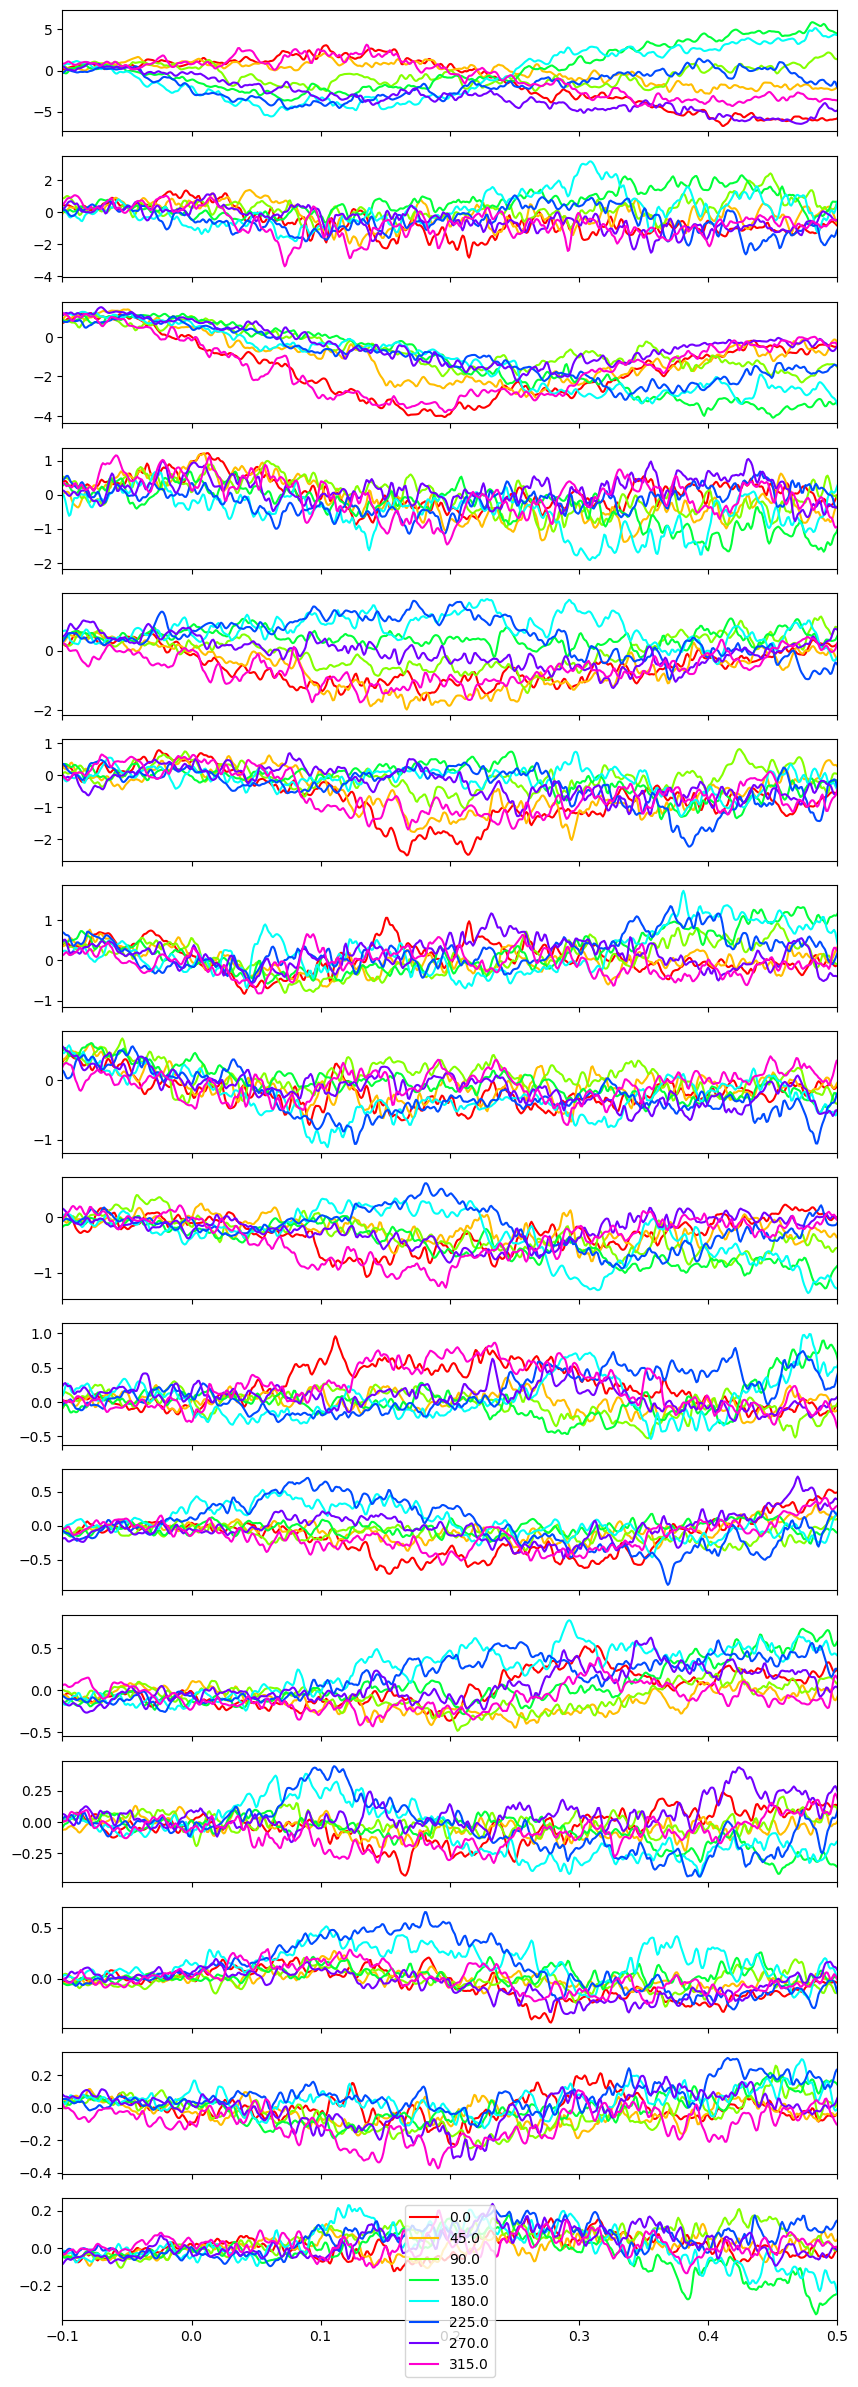

In [371]:
# t_rng = (-0.1, 0.5)
# t_rng = (-0.5, 1)
t_rng = (-0.5, 1.5)
fig, ax = plt.subplots(nrows=context_dim, sharex=True, figsize=(10, 30))


def smooth(x, window_len=11, window="hamming"):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len < 3:
        return x
    if window == "hanning":
        w = np.hanning(window_len)
    elif window == "hamming":
        w = np.hamming(window_len)
    elif window == "blackman":
        w = np.blackman(window_len)
    elif window == "gaussian":
        w = np.hanning(window_len)
        w = np.exp(
            -0.5
            * (np.arange(window_len) - window_len // 2) ** 2
            / (window_len // 6) ** 2
        )
        w /= w.sum()
    else:
        raise ValueError("Window is on of 'hanning', 'hamming', 'blackman'")
    y = np.convolve(w / w.sum(), x, mode="valid")
    return y


for direction in np.unique(trials_df.cond_dir.values):
    print(direction)
    if np.isnan(direction):
        continue
    color = plt.cm.hsv(direction / 360)
    # color = plt.cm.twilight(direction / 360)
    # color = None
    val = trials_df.copy()
    val = val[val.ctr_hold_bump == False]
    val = val[val.cond_dir == direction]
    val = val[val.split != "none"]

    start_times = val.move_onset_time.values
    response = analysis.alligned_response(start_times, t_rng, pca=True)
    response = np.nanmean(response, axis=0)
    response = np.array(
        [
            smooth(response[:, i], window_len=11, window="gaussian")
            for i in range(response.shape[1])
        ]
    ).T
    t_interp_rng = np.linspace(t_rng[0], t_rng[1], response.shape[0])
    for i, a in enumerate(ax):
        a.plot(t_interp_rng, response[:, i], label=direction, color=color)

plt.legend()
plt.xlim(-0.1, 0.5)

## Spectrogram

In [622]:
# starts = trials_df["start_time"].values
val = trials_df.copy()
val = val[val.ctr_hold_bump == False]
# val = val[val.cond_dir == direction]
# val = val[val.split != "none"]
starts = val.move_onset_time.values

reach_intervals = np.array([starts - 1, starts + 1.5]).T

In [624]:
f, mid, lo, hi = analysis.power_spectrum(
    intervals=reach_intervals, pca=True, window_size=500
)

Text(0.5, 1.0, 'context power spectrums')

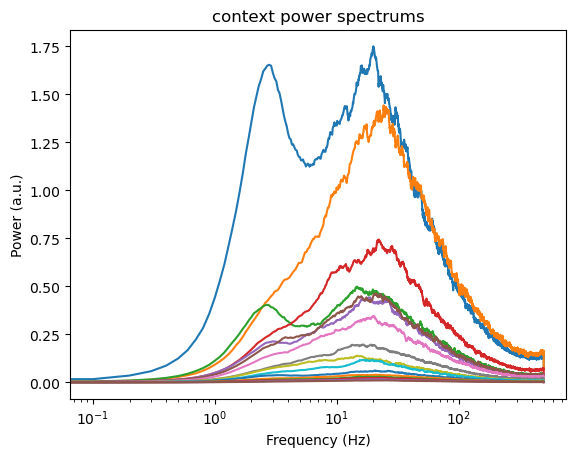

In [626]:
plt.plot(f, mid.T * f[:, None])
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (a.u.)")
plt.title("context power spectrums")

# Behavior Decoding

In [ ]:
# Define decodeer type and fit

train_df = trials_df[trials_df.split == "train"]
train_df = train_df[train_df.ctr_hold_bump == False]
train_intervals = train_df.move_onset_time.values
train_rng = (-0.1, 0.5)
train_intervals = np.array(
    [train_intervals + train_rng[0], train_intervals + train_rng[1]]
).T

train_intervals[0]

t_feature = behavior_df.index.values
feature = behavior_df[["hand_vel_x", "hand_vel_y"]].values
# feature = behavior_df[["hand_pos_x", "hand_pos_y"]].values

# analysis.initialize_decoder("knn", n_neighbors=30, weights='distance', metric='cosine')
analysis.initialize_decoder(
    "knn",
    n_neighbors=30,
    weights="uniform",
)
analysis.initialize_decoder(
    "linear",
)
# analysis.fit_decoder(feature, t_feature, intervals=train_intervals,pca=False,interpolate=True, smooth_context=20)

analysis.fit_decoder(
    feature,
    t_feature,
    intervals=train_intervals,
    pca=False,
    interpolate=True,
    smooth_context=20,
)

In [ ]:
# Decode on test set

test_df = trials_df[trials_df.split == "val"]
test_df = test_df[test_df.ctr_hold_bump == False]

# test_df = train_df

test_intervals = test_df.move_onset_time.values
test_rng = (-0.5, 1)
test_intervals = np.array(
    [test_intervals + test_rng[0], test_intervals + test_rng[1]]
).T


predicted = [
    analysis.predict_decoder(interval, interpolate=True) for interval in test_intervals
]
test_directions = test_df.cond_dir.values
test_bump = test_df.ctr_hold_bump.values

Text(0.5, 0, 'time from move onset (s)')

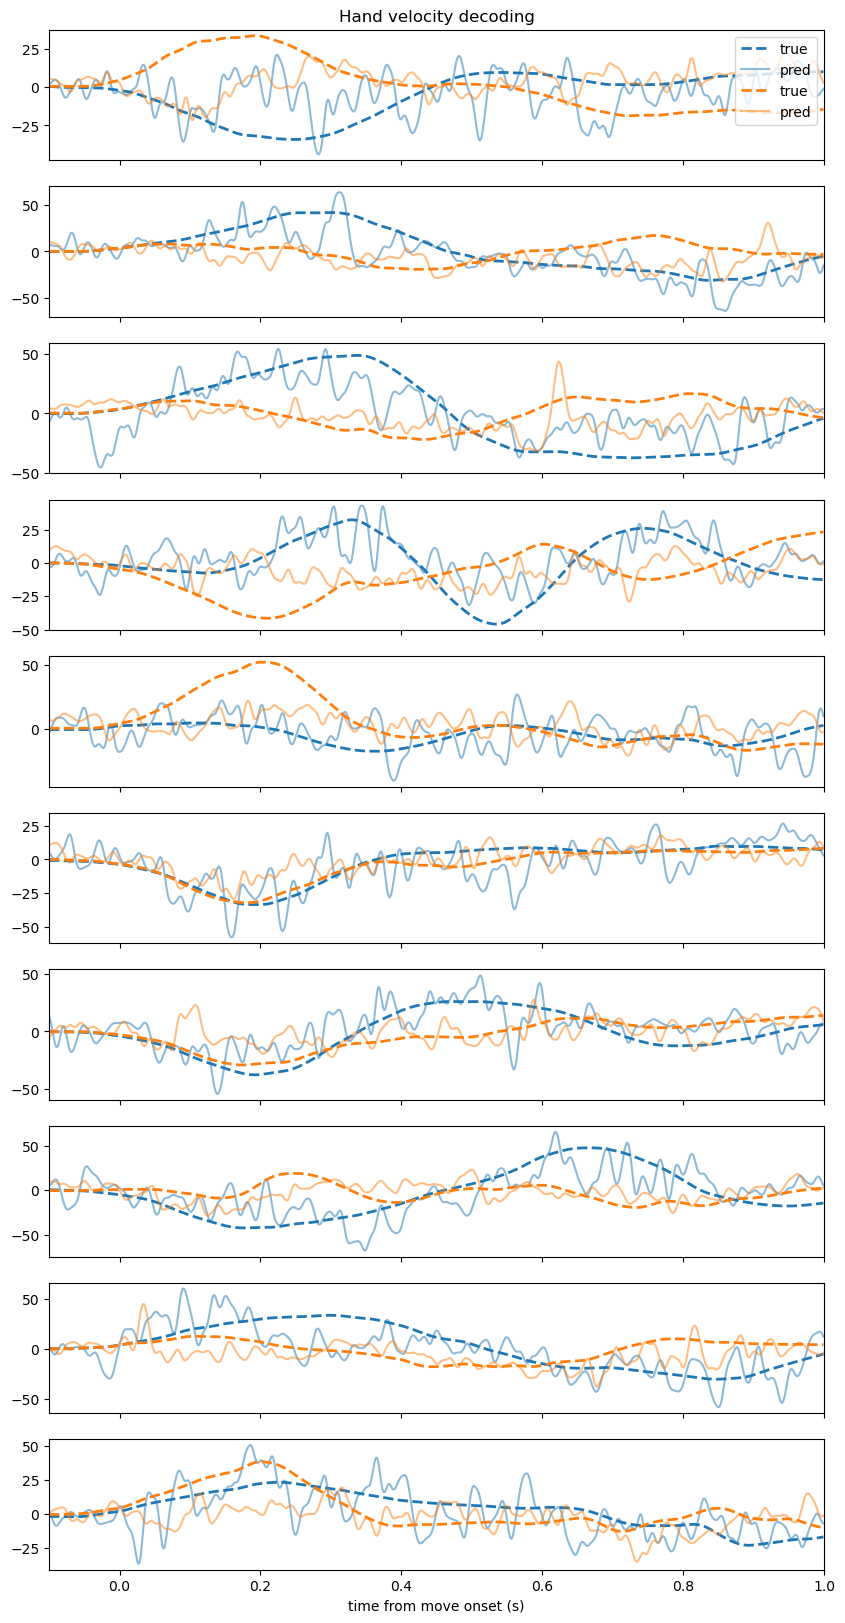

In [ ]:
# Example result traces

fig, ax = plt.subplots(nrows=10, sharex=True, figsize=(10, 20))

ind = np.where(np.logical_and(test_directions == 0, test_bump == 0))[0]
ind = np.where(test_bump == 0)[0][10:]
for i, ind_i in enumerate(ind[:10]):
    t, pred = predicted[ind_i]

    pred[:, 0] = np.convolve(
        pred[:, 0], np.hanning(21) / np.hanning(21).sum(), mode="same"
    )
    pred[:, 1] = np.convolve(
        pred[:, 1], np.hanning(21) / np.hanning(21).sum(), mode="same"
    )
    # pred = gaussian_filter1d(pred, 10, axis=0, mode="nearest")

    if t.size == 0:
        continue
    ind_behavior = np.digitize(t, behavior_df.index.values) - 1

    for j in range(feature.shape[1]):
        ax[i].plot(
            behavior_df.index.values[ind_behavior] - t[0] + test_rng[0],
            feature[ind_behavior, j],
            color=f"C{j}",
            ls="--",
            lw=2,
            # s=1,
            label="true",
        )
        ax[i].plot(
            t - t[0] + test_rng[0], pred[:, j], color=f"C{j}", alpha=0.5, label="pred"
        )

ax[0].set_title("Hand velocity decoding")
# ax[0].set_title("Hand position decoding")
ax[0].legend(loc="upper right")
ax[0].set_xlim(-0.1, 1)
plt.xlabel("time from move onset (s)")
# for t,pred in predicted[:10]:
#     if t.size==0: continue
#     ind_behavior = np.digitize(t, behavior_df.index.values) - 1
#     plt.plot(t-t[0], pred, color='C0', alpha=0.3)
#     plt.scatter(behavior_df.index.values[ind_behavior]-t[0], feature[ind_behavior,0], color='k', s=1)

(-0.1, 0.5)

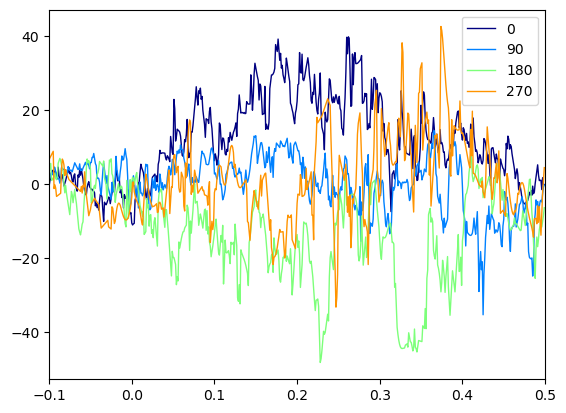

In [636]:
# Average results by direction

for direction in [0, 90, 180, 270]:
    color = plt.cm.jet(direction / 360)
    ind = np.where(np.logical_and(test_directions == direction, test_bump == 0))[0]
    # for i, ind_i in enumerate(ind[:5]):
    #     t, pred = predicted[ind_i]
    #     if t.size == 0:
    #         continue
    #     # ind_behavior = np.digitize(t, behavior_df.index.values) - 1
    #     plt.plot(t - t[0] + test_rng[0], pred, color=color, alpha=0.1)

    mean_pred = np.median(
        [predicted[ind_i][1] for ind_i in ind if predicted[ind_i][1].size > 0], axis=0
    )
    mean_t = predicted[ind[0]][0]
    plt.plot(
        mean_t - mean_t[0] + test_rng[0],
        mean_pred[:, 0],
        color=color,
        lw=1,
        label=direction,
    )

plt.legend()
plt.xlim(-0.5, 1)
plt.xlim(-0.1, 0.5)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


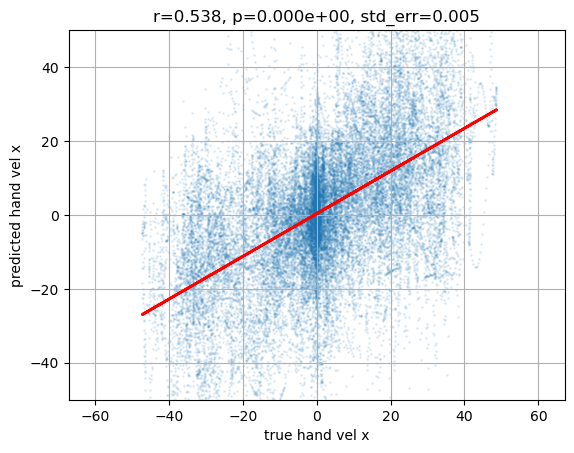

In [637]:
true_results = []
pred_results = []

for t_pred, pred in predicted:
    if t_pred.size == 0:
        continue
    ind_behavior = np.digitize(t_pred, t_feature) - 1
    true_results.extend(feature[ind_behavior, 0])
    pred_results.extend(pred[:, 0])
true_results = np.array(true_results)
pred_results = np.array(pred_results)

plt.scatter(true_results, pred_results, s=1, alpha=0.1)

from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(true_results, pred_results)
plt.plot(true_results, slope * true_results + intercept, color="r", lw=2)
plt.xlabel("true hand vel x")
plt.ylabel("predicted hand vel x")
plt.title(f"r={r_value:.3f}, p={p_value:.3e}, std_err={std_err:.3f}")
plt.axis("equal")
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.grid()
plt.show()

In [ ]:
# residuals analysis
distance_error = np.sqrt(((true_results - pred_results) ** 2).sum(axis=-1))

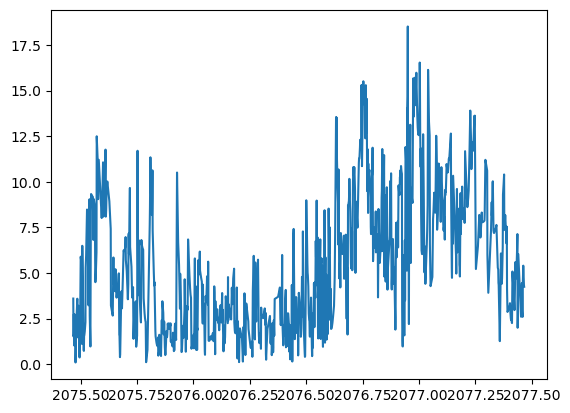

In [ ]:
for t_pred, pred in predicted:
    if t_pred.size == 0:
        continue
    ind_behavior = np.digitize(t_pred, t_feature) - 1
    true_results = feature[ind_behavior, :]
    # break

distance_error = np.sqrt(((true_results - pred) ** 2).sum(axis=-1))

plt.plot(t_pred, distance_error)